<a href="https://colab.research.google.com/github/Pakeith0805/SparkPlus_Assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SparkPlusの採用課題です。

- ラベル「0」： airplane（飛行機）
- ラベル「1」： automobile（自動車）
- ラベル「2」： bird（鳥）
- ラベル「3」： cat（猫）
- ラベル「4」： deer（鹿）
- ラベル「5」： dog（犬）
- ラベル「6」： frog（カエル）
- ラベル「7」： horse（馬）
- ラベル「8」： ship（船）
- ラベル「9」： truck（トラック）

# 前処理

In [32]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [33]:
# ちゃんとgpuになってるか確認。
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [34]:
# 前処理をまとめる
transform = transforms.Compose([
    transforms.ToTensor(), # 画像をTensorクラスに変えて、チャネルファーストに変えてくれる。
    transforms.Normalize((0.5,), (0.5,)) # 平均、標準偏差を0.5に
])

# 訓練用データセットと検証用データセットを作成
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
vilidation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

In [35]:
# データを作る。
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(vilidation_dataset, batch_size=32, shuffle=False)

In [36]:
# CNNを実装。
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 32×32の画像が16×16になる。
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 16×16の画像が8×8になる。
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 8×8の画像が4×4になる。
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes) # in_featuresには1次元ベクトルにして渡す。4×4が128個ある。out_featuresは何個に分類するか。
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # x.size(0)はバッチ数を表す。(32, 4×4×128)という形になる。
        x = self.classifier(x)
        return x

In [37]:
# modelを作成
model = CNN(10) # 10はクラス数
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [38]:
# 損失関数とoptimizerを設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) # weight_decayで重みづけが大きくなりすぎないようにしている。

In [39]:
# 学習のループ
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # 勾配の初期化
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        prob_pred = torch.softmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    #accs.append(running_acc)
    accs.append(running_acc.cpu())
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.3485005537211248, acc: 0.5114163756370544,      val loss: 1.009759777079756, val acc: 0.6441693305969238
epoch: 1, loss: 0.8828738178492965, acc: 0.6909589171409607,      val loss: 0.8224534072434179, val acc: 0.7102635502815247
epoch: 2, loss: 0.7147155384070127, acc: 0.7518793940544128,      val loss: 0.7548053405536249, val acc: 0.7386181950569153
epoch: 3, loss: 0.6110017237778436, acc: 0.7885276675224304,      val loss: 0.6992752917658407, val acc: 0.7585862278938293
epoch: 4, loss: 0.5320601835703895, acc: 0.8155789971351624,      val loss: 0.6994947950108744, val acc: 0.7560902237892151
epoch: 5, loss: 0.471999186776955, acc: 0.8361524343490601,      val loss: 0.7008004169018505, val acc: 0.7611820697784424
epoch: 6, loss: 0.41574244860914833, acc: 0.8543066382408142,      val loss: 0.824392875829063, val acc: 0.7487020492553711
epoch: 7, loss: 0.3719902101472754, acc: 0.8697016835212708,      val loss: 0.737477565249696, val acc: 0.7697683572769165
epoch: 8, l

In [40]:
labels

tensor([9, 3, 4, 0, 5, 2, 0, 0, 0, 4, 8, 9, 5, 3, 0, 2], device='cuda:0')

In [41]:
one_zero_labels = torch.where(labels == 0, 1, 0)
print(one_zero_labels)

tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')


In [42]:
prob = prob_pred[:, 0]

In [43]:
prob
# probはラベル0の確率。これ使ってroc曲線かける

tensor([4.4419e-06, 2.5244e-09, 1.1077e-09, 6.1673e-01, 1.1177e-04, 6.3946e-04,
        9.9897e-01, 9.9999e-01, 8.0616e-01, 2.0704e-08, 3.4089e-05, 1.1747e-03,
        1.9327e-10, 2.2777e-05, 9.1020e-01, 2.7049e-02], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [44]:
roc = roc_curve(one_zero_labels.cpu().detach().numpy(), prob.cpu().detach().numpy())

In [45]:
fpr, tpr, thresholds = roc

print(fpr)
# [0.   0.   0.25 0.25 0.5  0.5  1.  ]

print(tpr)
# [0.   0.25 0.25 0.5  0.5  1.   1.  ]

print(thresholds)
# [1.9 0.9 0.8 0.7 0.6 0.4 0.2]

[0. 0. 0. 1.]
[0.  0.2 1.  1. ]
[          inf 9.9999392e-01 6.1673051e-01 1.9326861e-10]


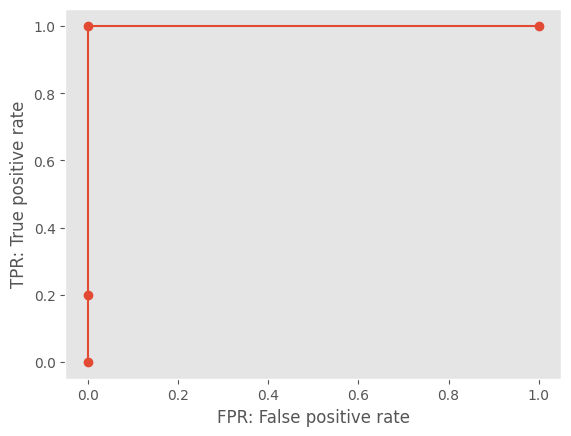

In [46]:
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

# 評価項目

In [47]:
# 正解率
print(accs[-1].cpu())
print(val_accs[-1].cpu())
# 混同行列
cm=confusion_matrix(y_true, y_pred)
val_cm=confusion_matrix(y_val_true, y_val_pred)
print(cm)
print(val_cm)
# 再現率：実際に真だったもののうち、モデルが真と判断した割合。
# 見逃しをなくしたいときに使われる。
# 別名真陽性率。
recall_per_class = cm.diagonal() / cm.sum(axis=1)
val_recall_per_class = val_cm.diagonal() / val_cm.sum(axis=1)
print(recall_per_class)
print(val_recall_per_class)
# 適合率：モデルが真と判断し、実際に真だった割合。猫と判断し、実際に猫だった割合。
# 誤検出をなくしたいときに使われる。
precision_per_class = cm.diagonal() / cm.sum(axis=0)
val_precision_per_class = val_cm.diagonal() / val_cm.sum(axis=0)
print(precision_per_class)
print(val_precision_per_class)
# F1スコア：適合率と再現率の調和平均。
f1_per_class = 2 * (precision_per_class * recall_per_class) / (precision_per_class + recall_per_class)
val_f1_per_class = 2 * (val_precision_per_class * val_recall_per_class) / (val_precision_per_class + val_recall_per_class)
print(f1_per_class)
print(val_f1_per_class)
# 偽陽性率：実際に偽だったったもののうち、モデルが間違えて真と判断した割合。

tensor(0.9199)
tensor(0.7620)
[[4631   23   90   29   40   21   11   18   89   48]
 [  21 4797   10    9    4    6   11    2   30  110]
 [ 107    8 4445  106  115   68   81   41   18   11]
 [  36    3  113 4286  102  252  108   64   22   14]
 [  32    1  107  100 4552   59   48   83   10    8]
 [  16    9   81  277   73 4420   37   73    6    8]
 [  14    9   78   98   51   41 4679    9   12    9]
 [  19    5   41   50   84   72   10 4700    9   10]
 [  86   28   14   29   15    6    9   11 4756   46]
 [  46  109   11   18    5   14    9   18   42 4728]]
[[689  10  93  40  30   5  12  14  51  56]
 [  8 819   3   8   4   4   8   1  25 120]
 [ 27   0 664  80  63  57  72  23   5   9]
 [  8   3  35 678  56 126  49  30   7   8]
 [  4   2  56  72 740  25  43  51   4   3]
 [  3   2  36 181  48 663  22  33   2  10]
 [  1   0  24  91  28  11 834   5   2   4]
 [  7   2  28  58  53  52  14 772   3  11]
 [ 23  16  16  23   9   4   4   3 870  32]
 [ 11  39  10  16   3   5   3   2  21 890]]
[0.9262 

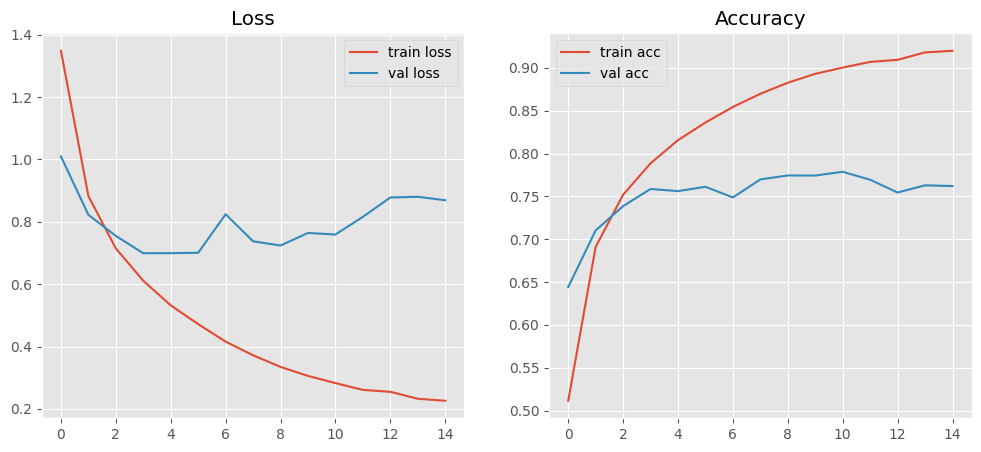

In [48]:
plt.style.use("ggplot")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1行2列のサブプロット

# 左のグラフ(損失)
axes[0].plot(losses, label="train loss")
axes[0].plot(val_losses, label="val loss")
axes[0].legend()
axes[0].set_title("Loss")

# 右のグラフ(精度)
axes[1].plot(accs, label="train acc")
axes[1].plot(val_accs, label="val acc")
axes[1].legend()
axes[1].set_title("Accuracy")

plt.show()

In [49]:
print(accs)
print(val_accs)

[tensor(0.5114), tensor(0.6910), tensor(0.7519), tensor(0.7885), tensor(0.8156), tensor(0.8362), tensor(0.8543), tensor(0.8697), tensor(0.8826), tensor(0.8930), tensor(0.9003), tensor(0.9069), tensor(0.9093), tensor(0.9180), tensor(0.9199)]
[tensor(0.6442), tensor(0.7103), tensor(0.7386), tensor(0.7586), tensor(0.7561), tensor(0.7612), tensor(0.7487), tensor(0.7698), tensor(0.7744), tensor(0.7743), tensor(0.7787), tensor(0.7694), tensor(0.7545), tensor(0.7629), tensor(0.7620)]
